In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
# Example: data = pd.read_csv('customer_data.csv')
data = pd.read_csv('customer_segmentation_data.csv')

# Display the first few rows
print(data.head())


   id  age  gender  income  spending_score  membership_years  \
0   1   38  Female   99342              90                 3   
1   2   21  Female   78852              60                 2   
2   3   60  Female  126573              30                 2   
3   4   40   Other   47099              74                 9   
4   5   65  Female  140621              21                 3   

   purchase_frequency preferred_category  last_purchase_amount  
0                  24          Groceries                113.53  
1                  42             Sports                 41.93  
2                  28           Clothing                424.36  
3                   5      Home & Garden                991.93  
4                  25        Electronics                347.08  


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1000 non-null   int64  
 1   age                   1000 non-null   int64  
 2   gender                1000 non-null   object 
 3   income                1000 non-null   int64  
 4   spending_score        1000 non-null   int64  
 5   membership_years      1000 non-null   int64  
 6   purchase_frequency    1000 non-null   int64  
 7   preferred_category    1000 non-null   object 
 8   last_purchase_amount  1000 non-null   float64
dtypes: float64(1), int64(6), object(2)
memory usage: 70.4+ KB


## It is observed that the data has no null values.It has 9 columns and 1000 rows.

In [28]:
data.describe()

,id,age,income,spending_score,membership_years,purchase_frequency,last_purchase_amount
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,43.783000,88500.800000,50.685000,5.46900,26.596000,492.348670
std,288.819436,15.042213,34230.771122,28.955175,2.85573,14.243654,295.744253
min,1.000000,18.000000,30004.000000,1.000000,1.00000,1.000000,10.400000
25%,250.750000,30.000000,57911.750000,26.000000,3.00000,15.000000,218.762500
50%,500.500000,45.000000,87845.500000,50.000000,5.00000,27.000000,491.595000
75%,750.250000,57.000000,116110.250000,76.000000,8.00000,39.000000,747.170000
max,1000.000000,69.000000,149973.000000,100.000000,10.00000,50.000000,999.740000


## Id is not important.So let's drop it.

In [29]:
data = data.drop(["id","preferred_category"],axis = 1)

In [30]:
# One-hot encode 'gender' and 'preferred_category'
encoded_data = pd.get_dummies(data, columns=['gender'])

In [31]:
# Standardize the numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(encoded_data)

In [32]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

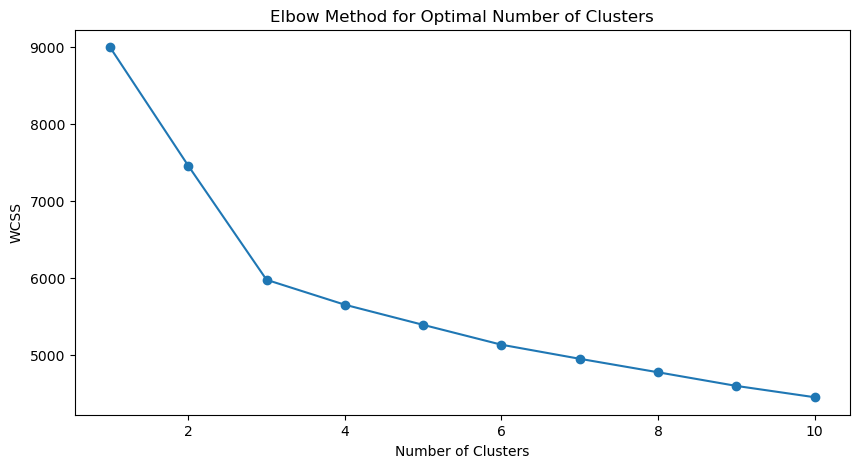

In [33]:
# Plot the Elbow Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

The Elbow plot generated shows the Within-Cluster Sum of Squares (WCSS) values for different numbers of clusters. To determine the optimal number of clusters, look for the "elbow point," where the rate of decrease in WCSS slows down significantly. This indicates that adding more clusters beyond this point provides diminishing returns in terms of reducing WCSS.

Analysis:
From the plot, we can see a significant drop in WCSS from 1 to 3 clusters, after which the reduction becomes more gradual. The "elbow" appears to be around 3 clusters, suggesting that this is an optimal choice for the number of clusters for customer segmentation analysis. Beyond 3 clusters, the decrease in WCSS is less pronounced, indicating that adding more clusters may not substantially improve the segmentation.

We can proceed with applying K-Means using 4 clusters to segment the customers effectively.

In [34]:
# Apply K-Means Clustering with the chosen number of clusters(4)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original dataset
data['Cluster'] = cluster_labels



## Validating the clusters -  Silhouette Analysis

Average silhouette score: 0.25943532178435247


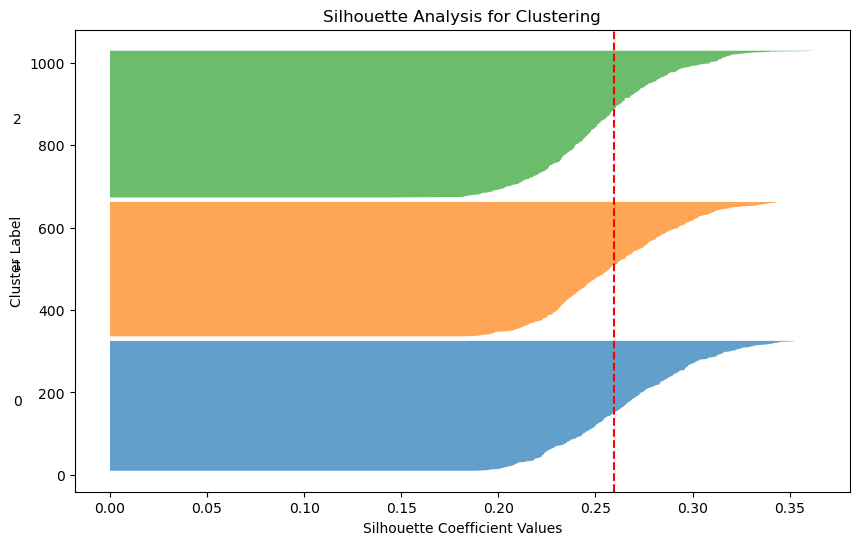

In [40]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import numpy as np

X = scaled_data
n_clusters =3

# Calculate the silhouette score for the clustering
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f"Average silhouette score: {silhouette_avg}")

# Silhouette analysis for each data point
sample_silhouette_values = silhouette_samples(X, kmeans.labels_)

# Plotting the silhouette analysis
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()

    # Plotting the silhouette values for this cluster
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.7)

    # Label the silhouette plots with their cluster numbers
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Silhouette Analysis for Clustering")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.show()


## Analyse and interpret the clusters

In [35]:
# Add the cluster labels to the original data
data['Cluster'] = kmeans.labels_

# Calculate the mean values of each feature for each cluster
cluster_summary = data.groupby('Cluster').mean()



# Calculate median values for each cluster
cluster_median = data.groupby('Cluster').median()

# Calculate standard deviation for each cluster
cluster_std = data.groupby('Cluster').std()

# Display the results
print("Cluster Mean Values:\n", cluster_summary)
print("\nCluster Median Values:\n", cluster_median)
print("\nCluster Standard Deviations:\n", cluster_std)



Cluster Mean Values:
                age        income  spending_score  membership_years  \
Cluster                                                              
0        43.876582  88018.104430       51.696203          5.316456   
1        45.165138  88522.703364       51.788991          5.510703   
2        42.434174  88907.997199       48.778711          5.565826   

         purchase_frequency  last_purchase_amount  
Cluster                                            
0                 25.424051            458.018892  
1                 25.865443            521.438930  
2                 28.302521            496.090112  

Cluster Median Values:
           age   income  spending_score  membership_years  purchase_frequency  \
Cluster                                                                        
0        45.0  86801.5            51.0               5.0                26.0   
1        47.0  87418.0            54.0               5.0                26.0   
2        43.0  89688.0

C:\Users\DELL\AppData\Local\Temp\ipykernel_11856\4250782626.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_summary = data.groupby('Cluster').mean()
C:\Users\DELL\AppData\Local\Temp\ipykernel_11856\4250782626.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_median = data.groupby('Cluster').median()
C:\Users\DELL\AppData\Local\Temp\ipykernel_11856\4250782626.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for

Summary of Cluster Labels
Cluster 0: "Average Shoppers" – Moderate across all metrics.
Cluster 1: "High Value Customers" – Higher income, higher spending scores, and larger transactions.
Cluster 2: "Frequent Shoppers" – Younger, more frequent purchases, though with lower spending scores.
These labels help in targeting marketing strategies by tailoring offers and promotions to each group based on their behavior.

In [39]:
# Mapping cluster numbers to descriptive labels
cluster_labels = {
    0: 'Average Shoppers',
    1: 'High Value Customers',
    2: 'Frequent Buyers'
}

# Add a new column with descriptive cluster labels
data['Cluster_Label'] = data['Cluster'].map(cluster_labels)

# Display the first few rows of the data with the new labels
print(data.head())

# Save the segmented data
data.to_csv('segmented_customers.csv', index=False)




   age  gender  income  spending_score  membership_years  purchase_frequency  \
0   38  Female   99342              90                 3                  24   
1   21  Female   78852              60                 2                  42   
2   60  Female  126573              30                 2                  28   
3   40   Other   47099              74                 9                   5   
4   65  Female  140621              21                 3                  25   

   last_purchase_amount  Cluster         Cluster_Label  
0                113.53        0      Average Shoppers  
1                 41.93        0      Average Shoppers  
2                424.36        0      Average Shoppers  
3                991.93        1  High Value Customers  
4                347.08        0      Average Shoppers  


## Visualizing the clusters

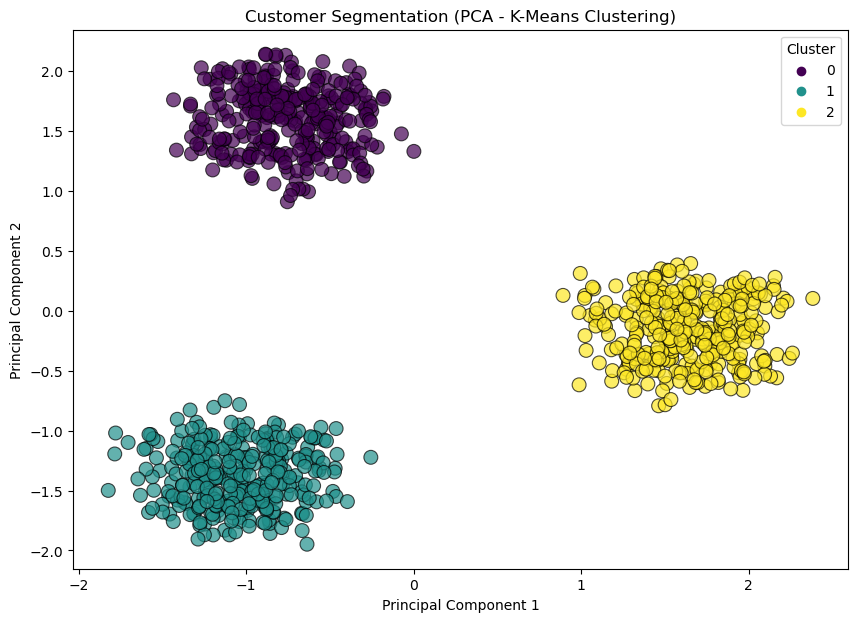

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Apply PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)  # 'scaled_data' is the scaled version of your original features

# Step 2: Create a DataFrame to store the PCA results and cluster labels
pca_df = pd.DataFrame(data=pca_data, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = kmeans.labels_

# Step 3: Visualize the clusters in a 2D plot using the principal components
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_df['Principal Component 1'], y=pca_df['Principal Component 2'], 
                hue=pca_df['Cluster'], palette='viridis', s=100, alpha=0.7, edgecolor='k')

# Adding plot title and labels
plt.title('Customer Segmentation (PCA - K-Means Clustering)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Display the plot with legend
plt.legend(title='Cluster')
plt.show()

